In [1]:
#importing required libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from sklearn.impute import SimpleImputer
from scipy import stats
import seaborn as sns
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

In [2]:
# Loading dataset
df = pd.read_csv('combined_dataset_cleaned.csv', parse_dates=['DATE'], index_col='DATE')

# Initializing scaler
scaler = MinMaxScaler()

# Fitting and transforming the 'UNRATE' column
df['UNRATE_scaled'] = scaler.fit_transform(df['UNRATE'].values.reshape(-1, 1))

# Defining the training and test size
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

# Splitting data into training and testing sets
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Original values for ARIMA model
y_train = train_data['UNRATE'].values
y_test = test_data['UNRATE'].values

# Defining the parameter grid for p and q with d fixed at 0 since the series is stationary
p_values = range(0, 5)
q_values = range(0, 5)
d_value = 0   
parameter_combinations = [(p, d_value, q) for p in p_values for q in q_values]

# Initializing variables to track the best parameters and lowest MSE
best_order = None
lowest_mse = float("inf")

# Performing grid search for ARIMA model on training data
for order in parameter_combinations:
    try:
        model = ARIMA(y_train, order=order)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=test_size)
        mse = mean_squared_error(y_test, predictions)
        if mse < lowest_mse:
            lowest_mse = mse
            best_order = order
        print(f"ARIMA{order} - MSE: {mse}")
    except Exception as e:
        print(f"ARIMA{order} - Failed with error: {e}")
        continue

print(f'\nBest ARIMA order: {best_order} with MSE: {lowest_mse}')

# Fitting ARIMA model on the training set
arima_model = ARIMA(y_train, order=best_order)
arima_result = arima_model.fit()

# Forecasting for the test set period
arima_forecast_test = arima_result.forecast(steps=test_size)

# Preparing LSTM data
X_train_scaled = train_data['UNRATE_scaled'].values
X_test_scaled = test_data['UNRATE_scaled'].values

def create_lstm_dataset(data, time_step=1):
    X, Y = [], []
    for I in range(len(data)-time_step):
        X.append(data[I:(I+time_step)])
        Y.append(data[I + time_step])
    return np.array(X), np.array(Y)

time_step = 10
X_train_lstm, y_train_lstm = create_lstm_dataset(X_train_scaled, time_step)
X_test_lstm, y_test_lstm = create_lstm_dataset(X_test_scaled, time_step)


X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Defining LSTM model
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=False))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Setting tuner
tuner = kt.RandomSearch(build_lstm_model,
                        objective='val_loss',
                        max_trials=10,
                        executions_per_trial=2,
                        directory='my_dir',
                        project_name='lstm_tuning')

# Running the tuner
tuner.search(X_train_lstm, y_train_lstm, epochs=10, validation_split=0.2, verbose=1)

# Getting the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal number of units: {best_hps.get('units')}")
print(f"Optimal dropout rate: {best_hps.get('dropout')}")

# Building the model with the optimal hyperparameters and train it
lstm_model = tuner.hypermodel.build(best_hps)
history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=5, validation_split=0.2, verbose=1)

# LSTM predictions
lstm_forecast_test_scaled = lstm_model.predict(X_test_lstm)

# Inverse transform LSTM predictions
lstm_forecast_test = scaler.inverse_transform(lstm_forecast_test_scaled)

# Adjust ARIMA predictions to match LSTM's time window
arima_forecast_test_adjusted = arima_forecast_test[time_step:]

ARIMA(0, 0, 0) - MSE: 5.568391936585201
ARIMA(0, 0, 1) - MSE: 5.563901947852724
ARIMA(0, 0, 2) - MSE: 5.57471177619178
ARIMA(0, 0, 3) - MSE: 5.562125986412743
ARIMA(0, 0, 4) - MSE: 5.577872360558313
ARIMA(1, 0, 0) - MSE: 5.219763113140757
ARIMA(1, 0, 1) - MSE: 5.1907674089676465
ARIMA(1, 0, 2) - MSE: 5.070155397201465
ARIMA(1, 0, 3) - MSE: 4.994516222540795
ARIMA(1, 0, 4) - MSE: 5.014527190202478
ARIMA(2, 0, 0) - MSE: 5.196463843644192
ARIMA(2, 0, 1) - MSE: 5.169461356706098
ARIMA(2, 0, 2) - MSE: 4.298367589142733
ARIMA(2, 0, 3) - MSE: 4.6594505935897095
ARIMA(2, 0, 4) - MSE: 3.9500295737956703
ARIMA(3, 0, 0) - MSE: 5.021867738132138
ARIMA(3, 0, 1) - MSE: 4.543659755190187
ARIMA(3, 0, 2) - MSE: 5.135845649849129
ARIMA(3, 0, 3) - MSE: 4.305330657065498
ARIMA(3, 0, 4) - MSE: 4.073288097627701
ARIMA(4, 0, 0) - MSE: 4.856736323315407
ARIMA(4, 0, 1) - MSE: 4.615721697904071
ARIMA(4, 0, 2) - MSE: 4.578203306339329
ARIMA(4, 0, 3) - MSE: 4.706333415951243
ARIMA(4, 0, 4) - MSE: 4.35155686767620

Meta-Model Mean Squared Error on Validation Set: 0.1977036979087198
Hybrid Model Mean Squared Error: 1.7060361703156777
Hybrid Model Mean Absolute Error: 0.4660063839076139
Hybrid Model Mean Absolute Percentage Error (MAPE): 0.0766885005416729


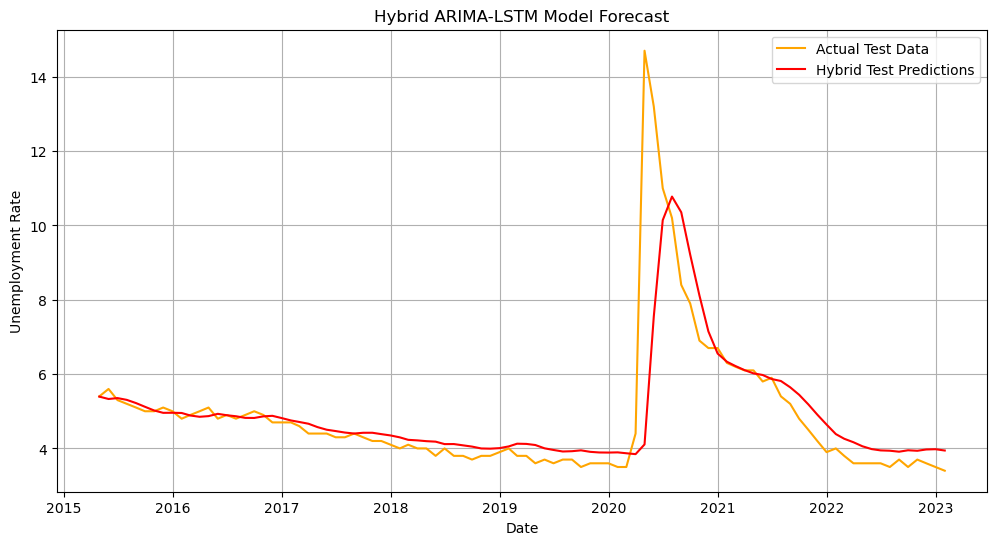

Hybrid model CSV file saved successfully.


In [3]:
# Stacking the ARIMA and LSTM predictions as features
X_meta = np.column_stack((arima_forecast_test_adjusted, lstm_forecast_test.flatten()))


X_meta_train, X_meta_val, y_meta_train, y_meta_val = train_test_split(X_meta, y_test[time_step:], test_size=0.3, random_state=42)

# Training a linear regression model as the meta-learner
meta_learner = LinearRegression()
meta_learner.fit(X_meta_train, y_meta_train)

# Predicting on the validation set
meta_val_predictions = meta_learner.predict(X_meta_val)

# Evaluating the meta-model
mse_meta = mean_squared_error(y_meta_val, meta_val_predictions)
print('Meta-Model Mean Squared Error on Validation Set:', mse_meta)


hybrid_test_predictions = meta_learner.predict(X_meta)

# Calculating performance metrics
mse_hybrid = mean_squared_error(y_test[time_step:], hybrid_test_predictions)
mae_hybrid = mean_absolute_error(y_test[time_step:], hybrid_test_predictions)
mape_hybrid = mean_absolute_percentage_error(y_test[time_step:], hybrid_test_predictions)

print('Hybrid Model Mean Squared Error:', mse_hybrid)
print('Hybrid Model Mean Absolute Error:', mae_hybrid)
print('Hybrid Model Mean Absolute Percentage Error (MAPE):', mape_hybrid)

# Plotting the hybrid model results for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[time_step:], y_test[time_step:], label='Actual Test Data', color='orange')
plt.plot(test_data.index[time_step:], hybrid_test_predictions, label='Hybrid Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('Hybrid ARIMA-LSTM Model Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Saving the results to a CSV file
results_hybrid_df = pd.DataFrame({
    'Date': test_data.index[time_step:],
    'Actual': y_test[time_step:],
    'ARIMA_Predicted': arima_forecast_test_adjusted,
    'LSTM_Predicted': lstm_forecast_test.flatten(),
    'Hybrid_Predicted': hybrid_test_predictions
})

results_hybrid_df.to_csv('actual_vs_predicted_hybrid.csv', index=False)

print('Hybrid model CSV file saved successfully.')